# Animal face classification

## Preprocessing
---

### Download the dataset from Kaggle

How to download kaggle data in Google Colab: https://www.kaggle.com/general/74235

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

Upload kaggle.json file.

In [ ]:
files.upload()

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Download Animal Faces dataset from https://www.kaggle.com/andrewmvd/animal-faces

In [5]:
!kaggle datasets download -d andrewmvd/animal-faces

 99% 689M/696M [00:07<00:00, 91.1MB/s]
100% 696M/696M [00:07<00:00, 95.5MB/s]


In [6]:
!unzip -qq animal-faces.zip

### Dataset overview

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pathlib import Path
import random
from sklearn.manifold import TSNE

plt.rcParams["font.size"] = 16

In [11]:
tf.__version__

'2.3.0'

In [8]:
class AnimalFaces:
  
  @classmethod
  def load(cls, path):
    index = {}
    sections = ['train', 'val']
    labels = ['cat', 'dog', 'wild']
    for section in sections:
      index[section] = {}
      for label in labels:
        p = '%s/%s/%s' % (path, section, label)
        paths = [str(p) for p in Path(p).rglob('*')]
        index[section][label] = paths
    return AnimalFaces(index)
  
  def __init__(self, index):
    self._index = index
    self._int2label = ['cat', 'dog', 'wild']
  
  def label2int(self, label):
    return self._int2label.index(label)
  
  def int2label(self, integer):
    return self._int2label[integer]

  def onehot2int(self, onehot):
    return np.where(onehot == 1)[0][0]
  
  def onehot2label(self, onehot):
    i = self.onehot2int(onehot)
    return self.int2label(i)

  def path2label(self, path):
    return path.split('/')[-2]
  
  def path2int(self, path):
    label = self.path2label(path)
    return self.label2int(label)
  
  @property
  def train_cats(self):
    return self._index['train']['cat']
  
  @property
  def train_dogs(self):
    return self._index['train']['dog']

  @property
  def train_wilds(self):
    return self._index['train']['wild']

  @property
  def val_cats(self):
    return self._index['val']['cat']  

  @property
  def val_dogs(self):
    return self._index['val']['dog']  

  @property
  def val_wilds(self):
    return self._index['val']['wild']


In [12]:
af = AnimalFaces.load('./afhq')

In [13]:
print('cats (train) : %d' % len(af.train_cats))
print('dogs (train) : %d' % len(af.train_dogs))
print('wilds (train) : %d' % len(af.train_wilds))
print('cats (val) : %d' % len(af.val_cats))
print('dogs (val) : %d' % len(af.val_dogs))
print('wilds (val) : %d' % len(af.val_wilds))

cats (train) : 5153
dogs (train) : 4739
wilds (train) : 4738
cats (val) : 500
dogs (val) : 500
wilds (val) : 500


In [14]:
def show_images(figsize, rows, cols, images, labels=None):
  plt.figure(figsize=figsize)
  for r in range(rows):
    for c in range(cols):
      i = r * cols + c
      if i == len(images):
        break
      plt.subplot(rows, cols, i + 1)
      plt.imshow(images[i])
      plt.axis('off')
      if labels != None:
        plt.title(labels[i])
  plt.show()

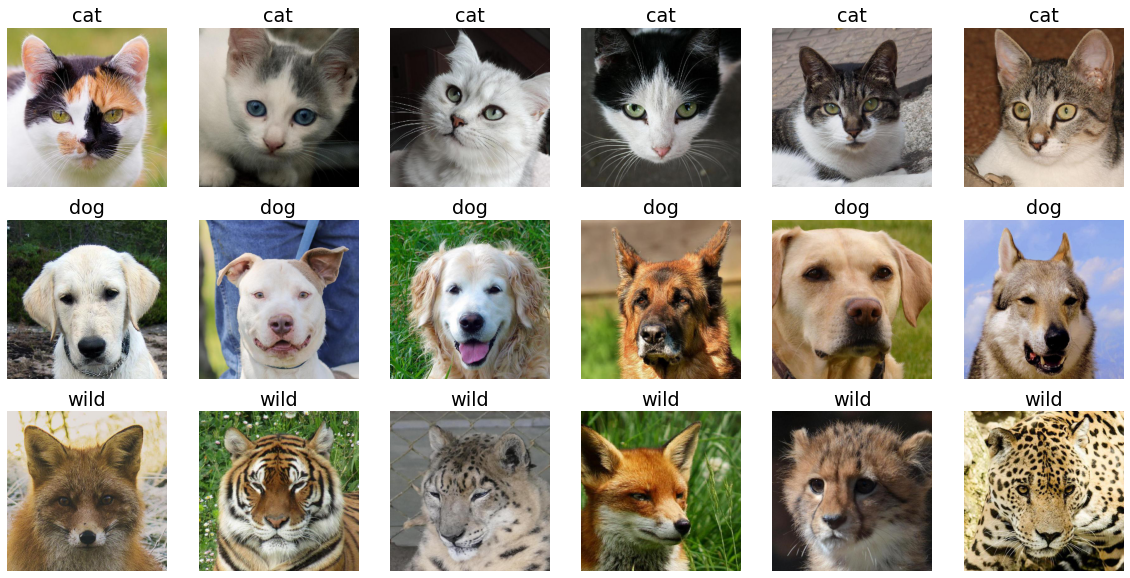

In [15]:
paths = af.train_cats[:6] + af.train_dogs[:6] + af.train_wilds[:6]
samples = [Image.open(path) for path in paths]
labels = [af.path2label(path) for path in paths]
show_images(figsize=(20, 10), rows=3, cols=6, images=samples, labels=labels)

### tf.data

In [16]:
@tf.function
def tf_load_image_and_onehot(path, int_label):
  onehot = tf.one_hot(int_label, depth=3)
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [224, 224], method='bilinear')
  image.set_shape([224, 224, 3])
  return image, onehot

In [17]:
train_paths = af.train_cats + af.train_dogs + af.train_wilds
val_paths = af.val_cats[:400] + af.val_dogs[:400] + af.val_wilds[:400]
test_paths = af.val_cats[400:] + af.val_dogs[400:] + af.val_wilds[400:]

random.shuffle(train_paths)
random.shuffle(val_paths)
random.shuffle(test_paths)

train_labels = [af.path2int(path) for path in train_paths]
val_labels = [af.path2int(path) for path in val_paths]
test_labels = [af.path2int(path) for path in test_paths]

train_img_ds = tf.data.Dataset.from_tensor_slices(train_paths)
train_label_ds = tf.data.Dataset.from_tensor_slices(train_labels)
val_img_ds = tf.data.Dataset.from_tensor_slices(val_paths)
val_label_ds = tf.data.Dataset.from_tensor_slices(val_labels)
test_img_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_label_ds = tf.data.Dataset.from_tensor_slices(test_labels)

train_ds = tf.data.Dataset.zip((train_img_ds, train_label_ds)).map(tf_load_image_and_onehot)
val_ds = tf.data.Dataset.zip((val_img_ds, val_label_ds)).map(tf_load_image_and_onehot)
test_ds = tf.data.Dataset.zip((test_img_ds, test_label_ds)).map(tf_load_image_and_onehot)

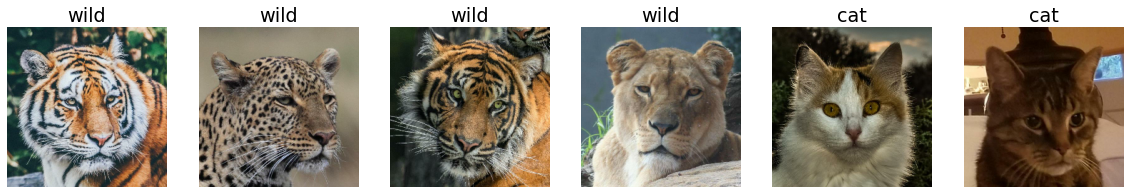

In [18]:
imgs, labels = [batch for batch in train_ds.batch(6).take(1)][0]
imgs = [img.numpy() for img in imgs]
labels = [af.onehot2label(label.numpy()) for label in labels]
show_images(figsize=(20, 6), rows=1, cols=6, images=imgs, labels=labels)

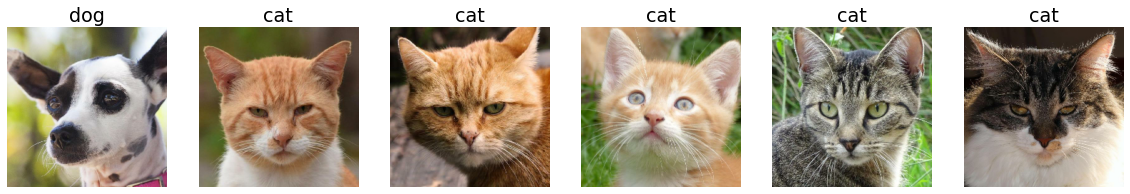

In [19]:
imgs, labels = [batch for batch in val_ds.batch(6).take(1)][0]
imgs = [img.numpy() for img in imgs]
labels = [af.onehot2label(label.numpy()) for label in labels]
show_images(figsize=(20, 6), rows=1, cols=6, images=imgs, labels=labels)

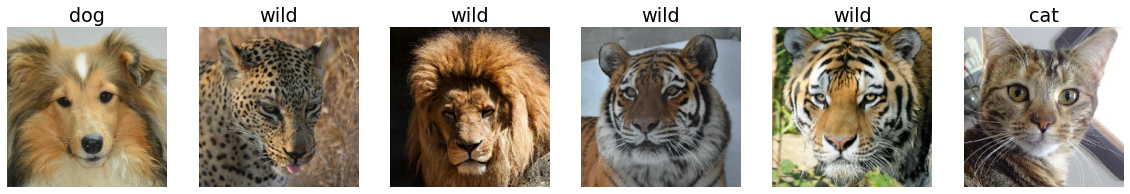

In [20]:
imgs, labels = [batch for batch in test_ds.batch(6).take(1)][0]
imgs = [img.numpy() for img in imgs]
labels = [af.onehot2label(label.numpy()) for label in labels]
show_images(figsize=(20, 6), rows=1, cols=6, images=imgs, labels=labels)

### Utilities

In [21]:
def show_training_history(hist, max_epoch, epoch_tick_step):
  xticks = np.arange(0, max_epoch, epoch_tick_step)
  xticklabels = [str(i+1) for i in xticks.tolist()]

  plt.figure(figsize=(20, 6))
  plt.subplot(1, 2, 1)
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.legend(['training', 'validation'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.xlim(0, max_epoch-1)
  plt.ylim(0,)
  plt.xticks(xticks, xticklabels)
  plt.grid()

  plt.subplot(1, 2, 2)
  plt.plot(hist.history['acc'])
  plt.plot(hist.history['val_acc'])
  plt.legend(['training', 'validation'], bbox_to_anchor=(1, 0), loc='lower right')
  plt.ylabel('acc')
  plt.xlabel('epoch')
  plt.xlim(0, max_epoch-1)
  plt.ylim(0, 1)
  plt.xticks(xticks, xticklabels)
  plt.yticks(np.linspace(0.0, 1.0, 11))
  plt.grid()

  plt.show()

In [33]:
def show_predictions(model, dataset, figsize):
  imgs, labels = next(iter(dataset.batch(36).take(1)))
  predicted_labels = model.predict(imgs)

  imgs = [img.numpy() for img in imgs]
  labels = [af.onehot2label(label.numpy()) for label in labels]
  predicted_labels = [af.int2label(np.argmax(label)) for label in predicted_labels]
  labels = ['correct #%s\npredicted #%s' % (c, p) for c, p in zip(labels, predicted_labels)]
  show_images(figsize=figsize, rows=6, cols=6, images=imgs, labels=labels)

In [23]:
def visualize_image_features(feature_extractor, dataset, num_samples, figsize, perplexity=30):
  imgs, labels = next(iter(dataset.batch(num_samples).take(1)))
  labels = [af.onehot2label(label.numpy()) for label in labels]
  features = feature_extractor.predict(imgs)
  f_reduced = TSNE(n_components=2, random_state=0, perplexity=perplexity).fit_transform(features)
  plt.figure(figsize=figsize)
  for label in ['cat', 'dog', 'wild']:
    mask = np.array([labels[i] == label for i in range(f_reduced.shape[0])])
    plt.scatter(f_reduced[mask, 0], f_reduced[mask, 1], label=label)
  plt.legend()
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
  plt.show()

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

## AnimalFaceNet-unit1
---

### Model

In [25]:
def animal_face_net_unit1():
  base_model = tf.keras.applications.ResNet50(
      input_shape=(224, 224, 3), 
      include_top=False, 
      weights='imagenet')
  
  # Freeze all the layers EXCEPT batch-normalization layers
  base_model.trainable = False
  for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
      layer.trainable =  True

  random_flip = tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal')
  data_augmentation = tf.keras.Sequential([random_flip,])

  inputs = tf.keras.layers.Input(shape=(224, 224, 3))
  x = data_augmentation(inputs)
  x = base_model(x, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(64, activation=tf.nn.leaky_relu)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(x)
  return tf.keras.Model(inputs, outputs, name='animal_face_net_unit1')

# model
model = animal_face_net_unit1()
print(model.summary())

Model: "animal_face_net_unit1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                131136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)      

### Training

In [26]:
# checkpoint
checkpoint_filepath = './animal_face_net_unit1_checkpoint/checkpoint'

# callbacks
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

initial_lr = 0.01
max_epoch = 40

def lr_decay(epoch):
    lr = initial_lr
    if epoch >= max_epoch*0.5: lr = initial_lr/10.
    elif epoch >= max_epoch*0.75: lr = initial_lr/100.
    return lr

lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay)

#training
model.compile(optimizer=tf.keras.optimizers.Adam(lr=initial_lr),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['acc'])

hist = model.fit(
    train_ds.batch(96).prefetch(buffer_size=tf.data.experimental.AUTOTUNE),
    epochs=max_epoch,
    validation_data=val_ds.batch(96).prefetch(buffer_size=tf.data.experimental.AUTOTUNE),
    callbacks=[model_checkpoint_callback, lr_decay_callback])

Epoch 1/40
153/153 [==============================] - 54s 352ms/step - loss: 0.4135 - acc: 0.8382 - val_loss: 1.8458 - val_acc: 0.3883
Epoch 2/40
153/153 [==============================] - 53s 345ms/step - loss: 0.2912 - acc: 0.8890 - val_loss: 1.0860 - val_acc: 0.6592
Epoch 3/40
153/153 [==============================] - 52s 342ms/step - loss: 0.2688 - acc: 0.8960 - val_loss: 1.9550 - val_acc: 0.4867
Epoch 4/40
153/153 [==============================] - 52s 339ms/step - loss: 0.2485 - acc: 0.9038 - val_loss: 2.4468 - val_acc: 0.6392
Epoch 5/40
153/153 [==============================] - 52s 343ms/step - loss: 0.2307 - acc: 0.9121 - val_loss: 4.6147 - val_acc: 0.4283
Epoch 6/40
153/153 [==============================] - 54s 350ms/step - loss: 0.2198 - acc: 0.9183 - val_loss: 1.4361 - val_acc: 0.6950
Epoch 7/40
153/153 [==============================] - 52s 341ms/step - loss: 0.2155 - acc: 0.9204 - val_loss: 4.0615 - val_acc: 0.4492
Epoch 8/40
153/153 [==============================] - 5

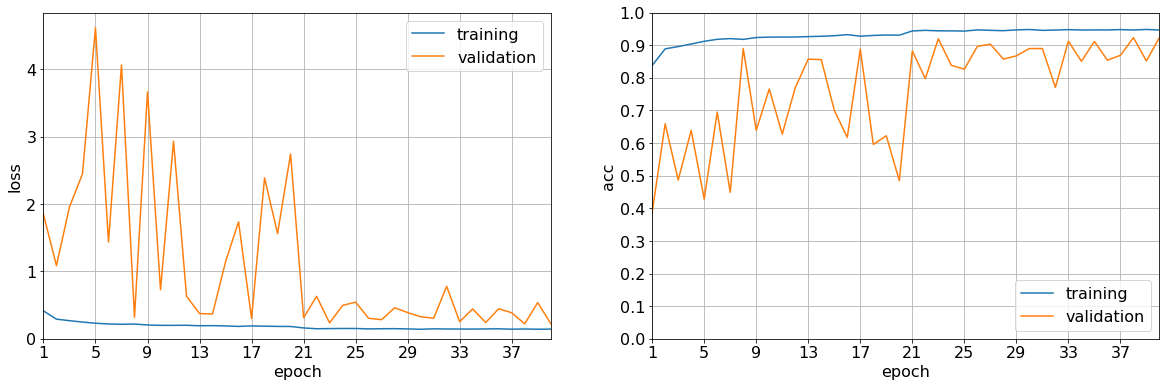

In [29]:
show_training_history(hist, max_epoch, epoch_tick_step=4)

In [30]:
path_model = '/content/drive/My Drive/ML/dcw_synth/models/animal_face_net_unit1'
path_best_model = '/content/drive/My Drive/ML/dcw_synth/models/animal_face_net_unit1_best'

# save the model
model.save(path_model)
# load and save the best model
model.load_weights(checkpoint_filepath)
model.save(path_best_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/ML/dcw_synth/models/animal_face_net_unit1/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/ML/dcw_synth/models/animal_face_net_unit1_best/assets


### Testing

In [31]:
best_model = tf.keras.models.load_model(path_best_model)
best_model.evaluate(test_ds.batch(32), verbose=1)

10/10 [==============================] - 1s 104ms/step - loss: 0.1384 - acc: 0.9433


[0.13838474452495575, 0.9433333277702332]

### Results

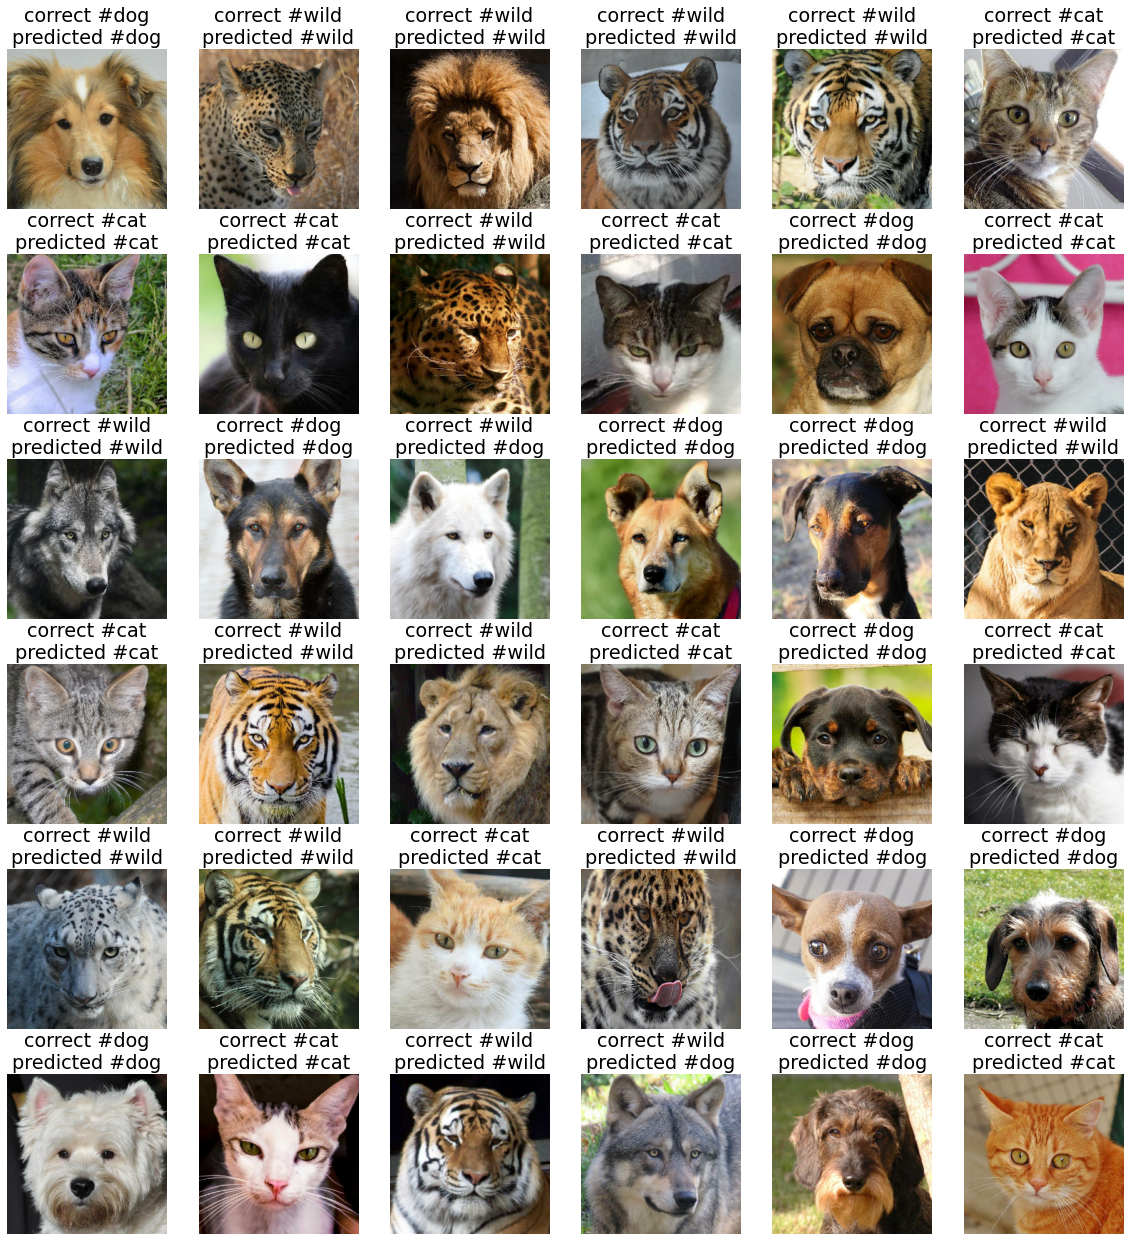

In [34]:
show_predictions(best_model, test_ds, figsize=(20, 22))

### Feature extraction

In [35]:
feature_extractor = tf.keras.models.Model(best_model.input, best_model.layers[-3].output)
feature_extractor.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                131136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
Total params: 23,719,104
Trainable params: 23,665,856
Non-trainable params: 53,248
_____________________________________

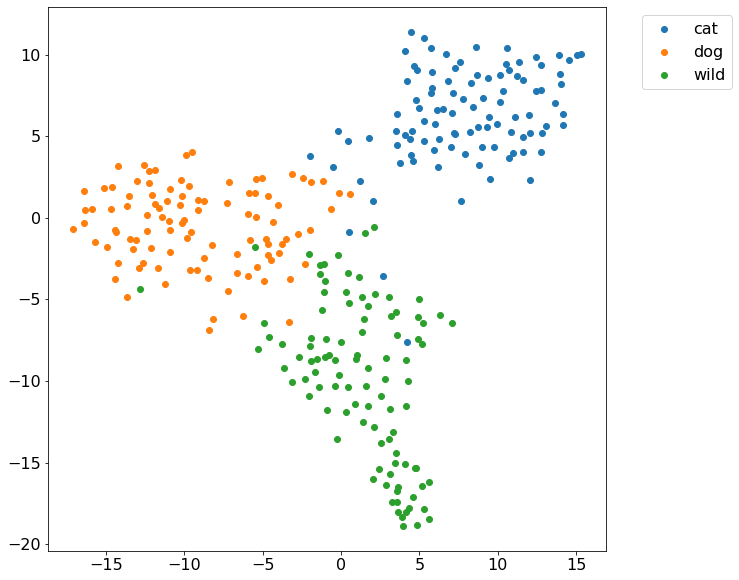

In [36]:
visualize_image_features(feature_extractor, test_ds, num_samples=1200, figsize=(10, 10), perplexity=32)

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

## AnimalFaceNet-unit2
---

### Model

In [82]:
def animal_face_net_unit2():
  # Fine-tune animal_face_net_unit1
  afn_unit1 = tf.keras.models.load_model(
      '/content/drive/My Drive/ML/dcw_synth/models/animal_face_net_unit1_best')
  
  base_model = afn_unit1.layers[2] # res-net-50
  base_model.trainable = True
  num_frozen_layers = 81
  # Freeze first 'num_frozen_layers' layers in the base model 
  # except the batch-normalization layers.
  for i in range(len(base_model.layers)):
    layer = base_model.layers[i]
    if i < num_frozen_layers and not isinstance(layer, tf.keras.layers.BatchNormalization):
      layer.trainable =  False

  afn_unit1._name = 'animal_face_net_unit2'
  return afn_unit1

# model
model = animal_face_net_unit2()
print(model.summary())

Model: "animal_face_net_unit2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                131136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)      

### Training

In [83]:
# checkpoint
checkpoint_filepath = './animal_face_net_unit2_checkpoint/checkpoint'

# callbacks
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

initial_lr = 1e-6
max_epoch = 30

def lr_decay(epoch):
    lr = initial_lr
    if epoch >= max_epoch*0.6: lr = initial_lr/10.
    elif epoch >= max_epoch*0.85: lr = initial_lr/100.
    return lr

lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay)

#training
model.compile(optimizer=tf.keras.optimizers.Adam(lr=initial_lr),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['acc'])

hist = model.fit(
    train_ds.batch(96).prefetch(buffer_size=tf.data.experimental.AUTOTUNE),
    epochs=max_epoch,
    validation_data=val_ds.batch(96).prefetch(buffer_size=tf.data.experimental.AUTOTUNE),
    callbacks=[model_checkpoint_callback, lr_decay_callback])

Epoch 1/30
153/153 [==============================] - 73s 477ms/step - loss: 0.1600 - acc: 0.9400 - val_loss: 1.7999 - val_acc: 0.6117
Epoch 2/30
153/153 [==============================] - 72s 471ms/step - loss: 0.1376 - acc: 0.9500 - val_loss: 0.2200 - val_acc: 0.9275
Epoch 3/30
153/153 [==============================] - 72s 471ms/step - loss: 0.1238 - acc: 0.9548 - val_loss: 0.1954 - val_acc: 0.9300
Epoch 4/30
153/153 [==============================] - 72s 473ms/step - loss: 0.1126 - acc: 0.9602 - val_loss: 0.1604 - val_acc: 0.9458
Epoch 5/30
153/153 [==============================] - 72s 468ms/step - loss: 0.1073 - acc: 0.9617 - val_loss: 0.1724 - val_acc: 0.9433
Epoch 6/30
153/153 [==============================] - 71s 465ms/step - loss: 0.1002 - acc: 0.9643 - val_loss: 0.3955 - val_acc: 0.8658
Epoch 7/30
153/153 [==============================] - 71s 464ms/step - loss: 0.0933 - acc: 0.9667 - val_loss: 0.2282 - val_acc: 0.9150
Epoch 8/30
153/153 [==============================] - 7

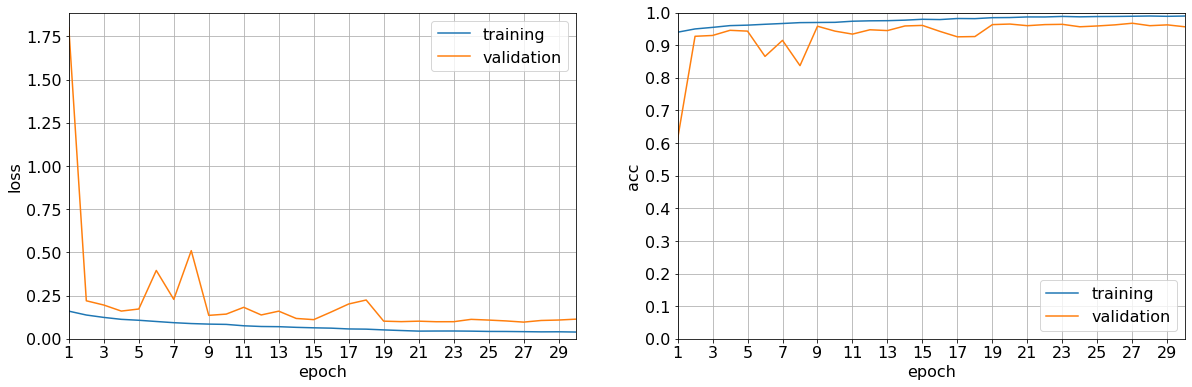

In [86]:
show_training_history(hist, max_epoch, epoch_tick_step=2)

In [95]:
path_model = '/content/drive/My Drive/ML/dcw_synth/models/animal_face_net_unit2'
path_best_model = '/content/drive/My Drive/ML/dcw_synth/models/animal_face_net_unit2_best'

# save the model
model.save(path_model)
# load and save the best model
model.load_weights(checkpoint_filepath)
model.save(path_best_model)

INFO:tensorflow:Assets written to: /content/drive/My Drive/ML/dcw_synth/models/animal_face_net_unit2/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/ML/dcw_synth/models/animal_face_net_unit2_best/assets


### Testing

In [96]:
best_model = tf.keras.models.load_model(path_best_model)
best_model.evaluate(test_ds.batch(32), verbose=1)

10/10 [==============================] - 1s 94ms/step - loss: 0.0716 - acc: 0.9733


[0.0716032013297081, 0.9733333587646484]

### Results

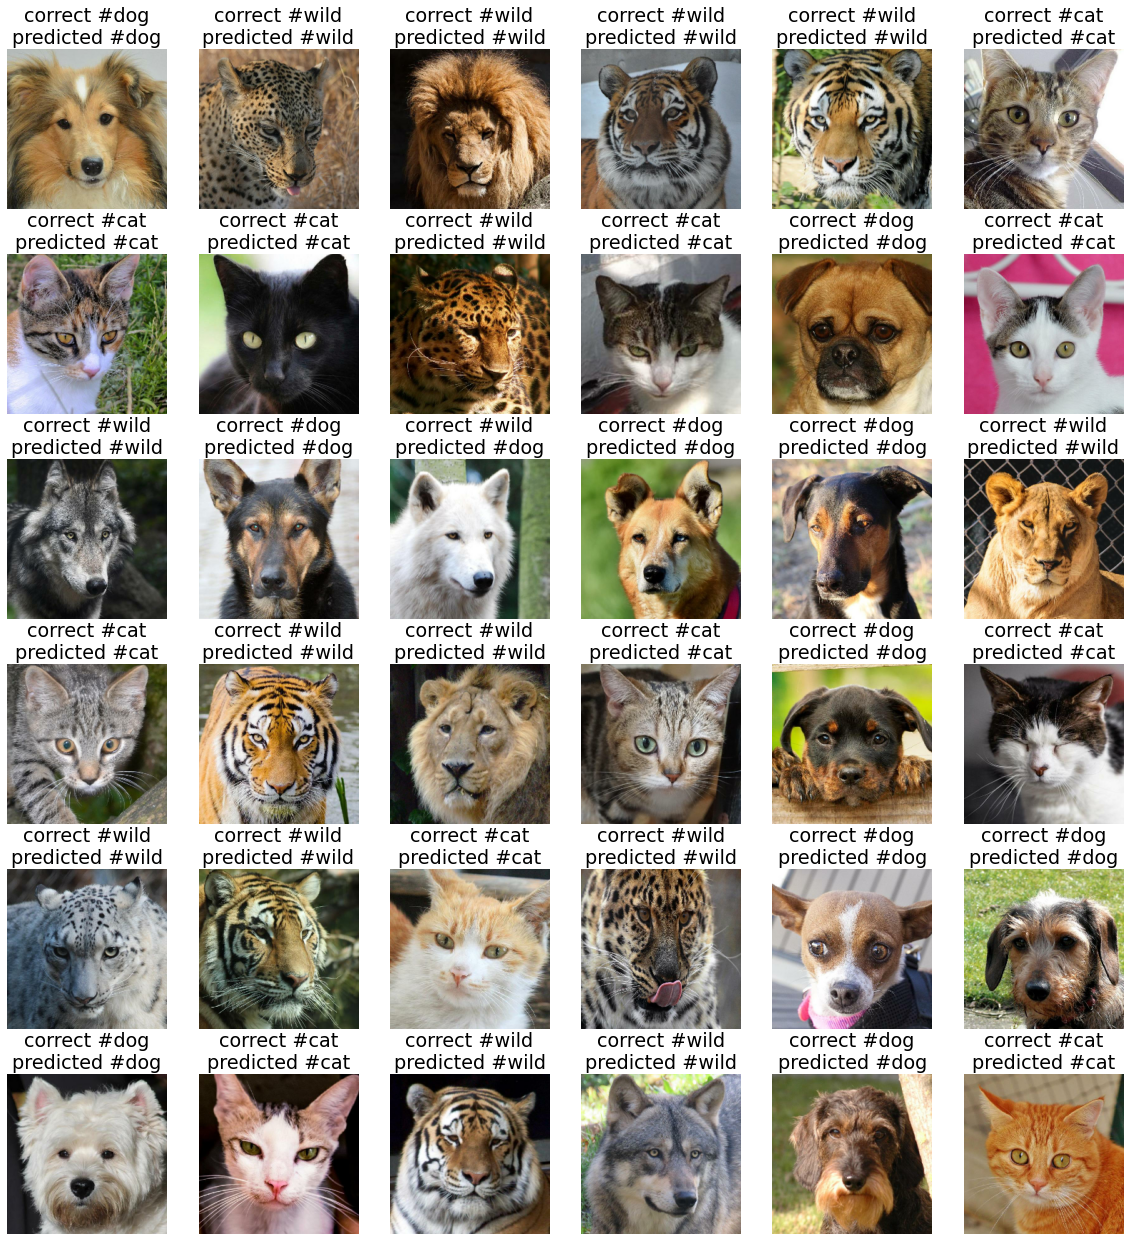

In [97]:
show_predictions(best_model, test_ds, figsize=(20, 22))

### Feature extraction

In [91]:
feature_extractor = tf.keras.models.Model(best_model.input, best_model.layers[-3].output)
feature_extractor.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                131136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
Total params: 23,719,104
Trainable params: 23,665,856
Non-trainable params: 53,248
_____________________________________

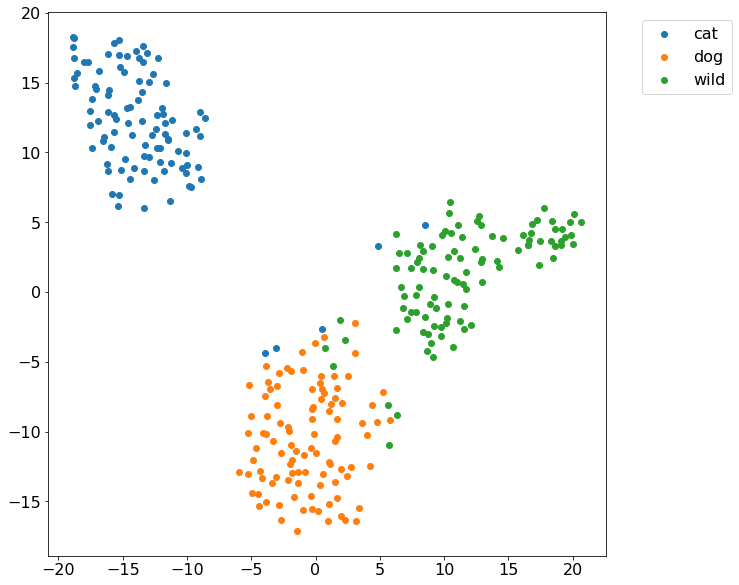

In [94]:
visualize_image_features(feature_extractor, test_ds, num_samples=1200, figsize=(10, 10), perplexity=30)

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>